In [1]:
#Importing relevant Libraries
import seaborn as sns
from google.colab import drive
import os
import numpy as np
import pandas as pd
import pickle
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix, classification_report
from random import choice, seed

In [2]:
pip install tf-explain

     |████████████████████████████████| 51kB 4.5MB/s 


In [3]:
# Import explainer
#from tf_explain.core.smoothgrad import SmoothGrad
#from tf_explain.core.gradients_inputs import GradientsInputs
from tf_explain.core.integrated_gradients import IntegratedGradients
#from tf_explain.core.vanilla_gradients import VanillaGradients

# Instantiation of the explainer
#explainerSG = SmoothGrad()
#explainerVG = VanillaGradients()
explainerIG = IntegratedGradients()
#explainerGI = GradientsInputs()

In [4]:
#Importing the file from my drive
drive.mount('/content/drive')

Mounted at /content/drive


## Task 1

### Q1

In [5]:
#Load data
os.chdir(r'/content/drive/My Drive/ECE1512/Project1')
with open('MNIST1D.pkl', 'rb') as f:
  data = pickle.load(f)

In [6]:
from xai_utils import grad_cam # Importing grad cam model from xai_utils
#Load model
os.chdir(r'/content/drive/My Drive/ECE1512/Project1/models')
model=load_model('MNIST1D.h5')

In [7]:
#Creating empty dictionary to store number of correct predictions for each class label
classes = {}
keys = range(10)
for i in keys:
  classes[i] = 0

classes

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [8]:
all_preds = [] #To store all the predictions done on test data
all_probs = np.zeros((1000,10)) #To store all the probabilities or confidence score of the model for each image
for i in range(len(data['y_test'])):
  all_probs[i,:] = model.predict(np.expand_dims(np.expand_dims(data['x_test'][i], axis=0), axis=-1))[0]
  all_preds.append(np.argmax(all_probs[i])) #Appending prediction in the list
  if all_preds[i] == data['y_test'][i]:
    classes[data['y_test'][i]] += 1 #Class wise correct predictions

In [9]:
all_preds = np.array(all_preds)
print("Overall Classification Accuracy on test data is {}%".format(np.sum(all_preds == data['y_test'])*100/len(data['y_test'])))

Overall Classification Accuracy on test data is 87.7%


In [10]:
class_counts = np.unique(data['y_test'], return_counts=True)[1] #Actual number of images for each class label
for i in keys:
  print("Classification Accuracy on test data for class {} is {}%".format(i, np.round(classes[i]*100/class_counts[i],2)))

Classification Accuracy on test data for class 0 is 98.04%
Classification Accuracy on test data for class 1 is 80.77%
Classification Accuracy on test data for class 2 is 88.76%
Classification Accuracy on test data for class 3 is 94.34%
Classification Accuracy on test data for class 4 is 84.91%
Classification Accuracy on test data for class 5 is 81.63%
Classification Accuracy on test data for class 6 is 91.92%
Classification Accuracy on test data for class 7 is 86.46%
Classification Accuracy on test data for class 8 is 91.84%
Classification Accuracy on test data for class 9 is 78.43%


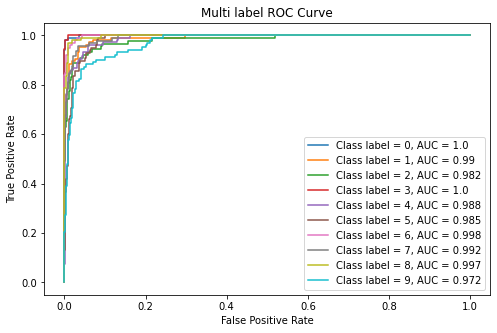

In [11]:
onehot_test = np.array(pd.get_dummies(pd.Series(data['y_test']))) #Onehot encoding the test labels for ROC
plt.figure(figsize = (8,5))
for i in range(10):
  fpr, tpr, _ = roc_curve(onehot_test[:,i],all_probs[:,i])   #https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
  plt.plot(fpr, tpr, label = 'Class label = {}, AUC = {}'.format(i, np.round(roc_auc_score(onehot_test[:,i],all_probs[:,i]),3)))
  
plt.title('Multi label ROC Curve') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

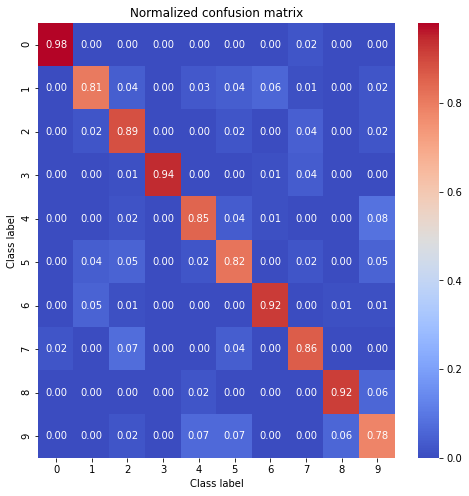

In [12]:
plt.figure(figsize = (8,8))
sns.heatmap(confusion_matrix(data['y_test'], all_preds, normalize='true'), annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.title('Normalized confusion matrix')
plt.xlabel('Class label')
plt.ylabel('Class label')
plt.show()

In [13]:
print("Precision, recall, f1 score for each class is shown through Classification report", classification_report(data['y_test'], all_preds), sep = '\n')

Precision, recall, f1 score for each class is shown through Classification report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       102
           1       0.88      0.81      0.84       104
           2       0.78      0.89      0.83        89
           3       1.00      0.94      0.97       106
           4       0.87      0.85      0.86       106
           5       0.79      0.82      0.80        98
           6       0.92      0.92      0.92        99
           7       0.86      0.86      0.86        96
           8       0.93      0.92      0.92        98
           9       0.76      0.78      0.77       102

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



### Q2

From the classification accuracy for each class label we can see that the accuracy is minimum for classes having label as 9 and 1 with 78.43% and 80.77% accuracy respectively.

In [14]:
target_indices = [] #List of list to store indices corresponding to each class label 
for i in range(10):
  target_indices.append(list(np.where(data['y_test'] == i)[0]))

In [15]:
org = np.unique(data['y'], return_counts = True)
for i in range(10):
  print("Number of training images for class {} is {}".format(org[0][i], org[1][i]))

Number of training images for class 0 is 398
Number of training images for class 1 is 396
Number of training images for class 2 is 411
Number of training images for class 3 is 394
Number of training images for class 4 is 394
Number of training images for class 5 is 402
Number of training images for class 6 is 401
Number of training images for class 7 is 404
Number of training images for class 8 is 402
Number of training images for class 9 is 398


In [16]:
tes = np.unique(data['y_test'], return_counts = True)
for i in range(10):
  print("Number of training images for class {} is {}".format(tes[0][i], tes[1][i]))

Number of training images for class 0 is 102
Number of training images for class 1 is 104
Number of training images for class 2 is 89
Number of training images for class 3 is 106
Number of training images for class 4 is 106
Number of training images for class 5 is 98
Number of training images for class 6 is 99
Number of training images for class 7 is 96
Number of training images for class 8 is 98
Number of training images for class 9 is 102


In [17]:
for9 = np.unique(all_preds[np.where(data['y_test'] == 9)[0]], return_counts = True)
for i in range(len(for9[0])):
  if for9[0][i] != 9:
    print("{} times class {} is predicted when the original class is 9".format(for9[1][i], for9[0][i]))
  else:
    print("{} times class {} is correctly predicted".format(for9[1][i], for9[0][i]))

2 times class 2 is predicted when the original class is 9
7 times class 4 is predicted when the original class is 9
7 times class 5 is predicted when the original class is 9
6 times class 8 is predicted when the original class is 9
80 times class 9 is correctly predicted


In [18]:
for9 = np.unique(all_preds[np.where(data['y_test'] == 1)[0]], return_counts = True)
for i in range(len(for9[0])):
  if for9[0][i] != 1:
    print("{} times class {} is predicted when the original class is 1".format(for9[1][i], for9[0][i]))
  else:
    print("{} times class {} is correctly predicted".format(for9[1][i], for9[0][i]))

84 times class 1 is correctly predicted
4 times class 2 is predicted when the original class is 1
3 times class 4 is predicted when the original class is 1
4 times class 5 is predicted when the original class is 1
6 times class 6 is predicted when the original class is 1
1 times class 7 is predicted when the original class is 1
2 times class 9 is predicted when the original class is 1


**Misclassification probabilites for actual class 9**

In [19]:
q = np.where(all_preds[np.where(data['y_test'] == 9)[0]]==2)[0]
print('Probabilities for class predicted as 2 when actual is 9', np.max(all_probs[np.where(data['y_test'] == 9)[0]][q], axis = 1))

Probabilities for class predicted as 2 when actual is 9 [0.97117686 0.99309522]


In [20]:
q = np.where(all_preds[np.where(data['y_test'] == 9)[0]]==4)[0]
print('Probabilities for class predicted as 4 when actual is 9', np.max(all_probs[np.where(data['y_test'] == 9)[0]][q], axis = 1))

Probabilities for class predicted as 4 when actual is 9 [0.54194754 0.99430591 0.54061282 0.81993699 0.92856801 0.79223686
 0.65931773]


In [21]:
q = np.where(all_preds[np.where(data['y_test'] == 9)[0]]==5)[0]
print('Probabilities for class predicted as 5 when actual is 9', np.max(all_probs[np.where(data['y_test'] == 9)[0]][q], axis = 1))

Probabilities for class predicted as 5 when actual is 9 [0.91506445 0.86363745 0.98613119 0.45203578 0.97228539 0.96049875
 0.80651653]


In [22]:
q = np.where(all_preds[np.where(data['y_test'] == 9)[0]]==8)[0]
print('Probabilities for class predicted as 8 when actual is 9', np.max(all_probs[np.where(data['y_test'] == 9)[0]][q], axis = 1))

Probabilities for class predicted as 8 when actual is 9 [0.99917406 0.99914587 0.99376065 0.99837828 0.70909202 0.99900001]


**Misclassification probabilites for actual class 1**

In [23]:
q = np.where(all_preds[np.where(data['y_test'] == 1)[0]]==2)[0]
print('Probabilities for class predicted as 2 when actual is 1', np.max(all_probs[np.where(data['y_test'] == 1)[0]][q], axis = 1))

Probabilities for class predicted as 2 when actual is 1 [0.58144635 0.97142959 0.9762333  0.93199545]


In [24]:
q = np.where(all_preds[np.where(data['y_test'] == 1)[0]]==4)[0]
print('Probabilities for class predicted as 4 when actual is 1', np.max(all_probs[np.where(data['y_test'] == 1)[0]][q], axis = 1))

Probabilities for class predicted as 4 when actual is 1 [0.51691294 0.46362311 0.83043289]


In [25]:
q = np.where(all_preds[np.where(data['y_test'] == 1)[0]]==5)[0]
print('Probabilities for class predicted as 5 when actual is 1', np.max(all_probs[np.where(data['y_test'] == 1)[0]][q], axis = 1))

Probabilities for class predicted as 5 when actual is 1 [0.41716    0.67047536 0.63961977 0.79697096]


In [26]:
q = np.where(all_preds[np.where(data['y_test'] == 1)[0]]==6)[0]
print('Probabilities for class predicted as 6 when actual is 1', np.max(all_probs[np.where(data['y_test'] == 1)[0]][q], axis = 1))

Probabilities for class predicted as 6 when actual is 1 [0.69306499 0.73972028 0.57149857 0.99457705 0.45754635 0.67978621]


In [27]:
q = np.where(all_preds[np.where(data['y_test'] == 1)[0]]==7)[0]
print('Probabilities for class predicted as 7 when actual is 1', np.max(all_probs[np.where(data['y_test'] == 1)[0]][q], axis = 1))

Probabilities for class predicted as 7 when actual is 1 [0.43579465]


In [28]:
q = np.where(all_preds[np.where(data['y_test'] == 1)[0]]==9)[0]
print('Probabilities for class predicted as 9 when actual is 1', np.max(all_probs[np.where(data['y_test'] == 1)[0]][q], axis = 1))

Probabilities for class predicted as 9 when actual is 1 [0.67406857 0.56149334]


## Task 2

### Grad CAM

In [29]:
def mnistheatmaps(label, method):
  seed(0) #For reproducibility
  index_label = choice(target_indices[label]) #Randomly select an index for a label
  input = data['x_test'][index_label]
  if method == "gradcam":
    explanation = grad_cam(model, np.expand_dims(np.expand_dims(input, axis=0), axis=-1), 'conv1d_2')

  else:
    inp = np.expand_dims(np.expand_dims(np.expand_dims(input, axis=0), axis=-1), axis = -1)
    explanation = explainerIG.explain((inp, None), model,all_preds[index_label])[:,0]
    explanation = ((explanation - min(explanation))/(max(explanation) - min(explanation)))

  threshold = np.sort(explanation)[-12]
  #Code taken from MNIST1D.ipynb
  plt.figure(figsize=(24,5))

  plt.subplot(1,4,1)
  plt.plot(input)
  plt.title('Input array for true digit '+ str(label))

  plt.subplot(1,4,2)
  plt.plot(explanation, 'r')
  plt.title('Explanation map from '+ str(method))

  plt.subplot(1,4,3)
  plt.plot(data['templates']['x'][label])
  plt.title('Template for digit '+ str(label))

  plt.subplot(1,4,4)
  plt.plot((input*(explanation>threshold)), 'r')
  plt.title('Highlighted input region (by '+ str(method) +' algorithm)')
  plt.show()
  print('True digit: ',label)
  print('Predicted digit: ',all_preds[index_label])
  print('Confidence score for the true digit: ',all_probs[index_label,label])
  print('Confidence score for the predicted digit: ',max(all_probs[index_label]))

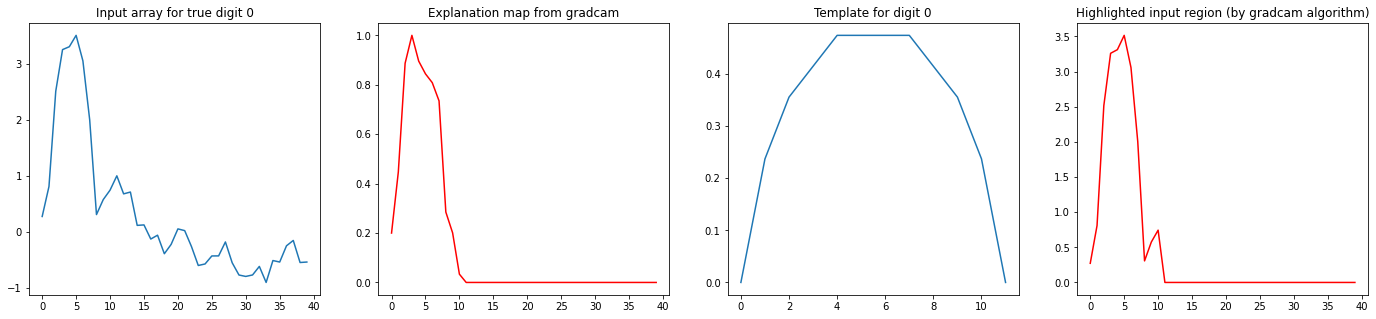

True digit:  0
Predicted digit:  0
Confidence score for the true digit:  0.9999557733535767
Confidence score for the predicted digit:  0.9999557733535767


In [30]:
mnistheatmaps(0, 'gradcam')

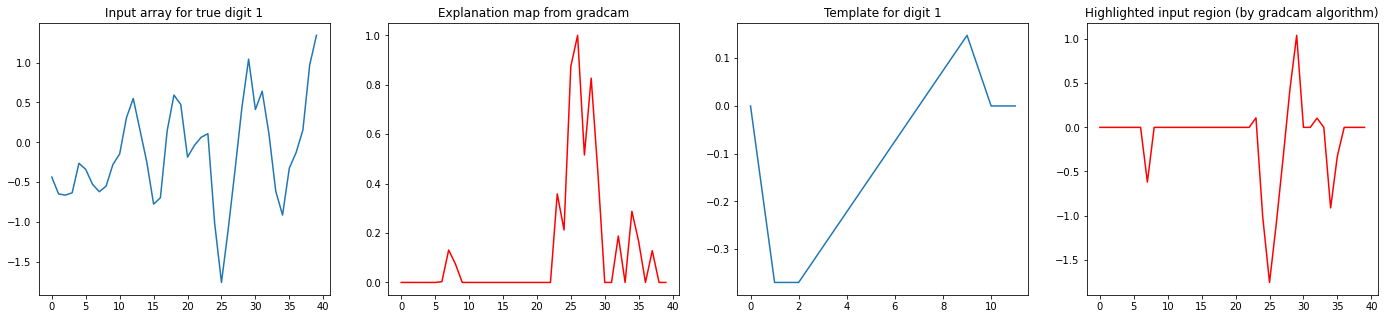

True digit:  1
Predicted digit:  1
Confidence score for the true digit:  0.7265156507492065
Confidence score for the predicted digit:  0.7265156507492065


In [31]:
mnistheatmaps(1, 'gradcam')

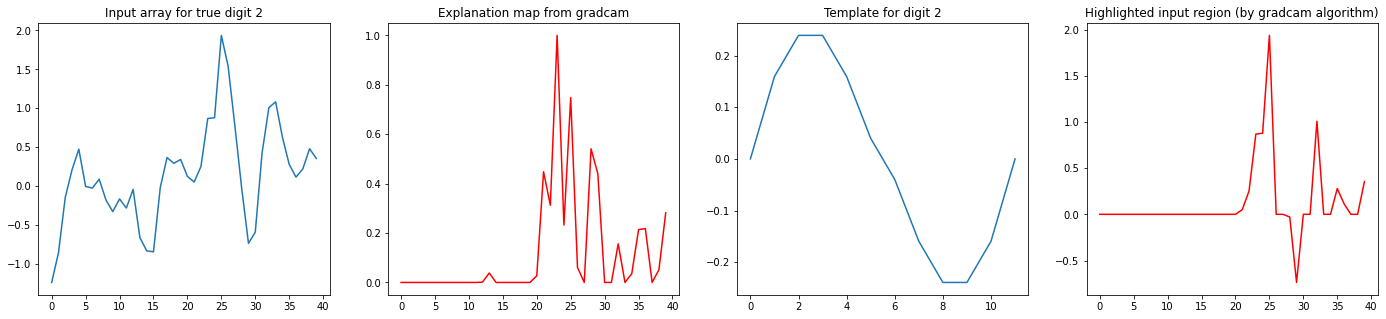

True digit:  2
Predicted digit:  7
Confidence score for the true digit:  0.30889150500297546
Confidence score for the predicted digit:  0.6897130608558655


In [32]:
mnistheatmaps(2, 'gradcam')

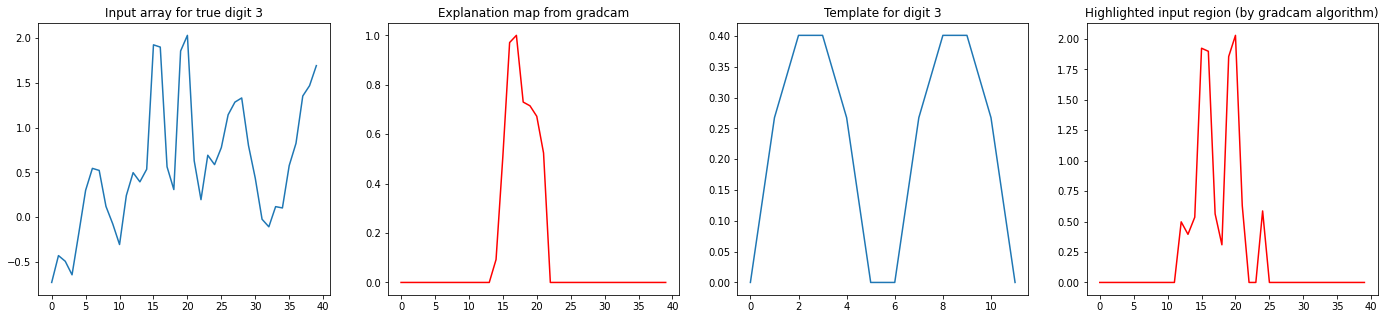

True digit:  3
Predicted digit:  3
Confidence score for the true digit:  0.8924388289451599
Confidence score for the predicted digit:  0.8924388289451599


In [33]:
mnistheatmaps(3, 'gradcam')

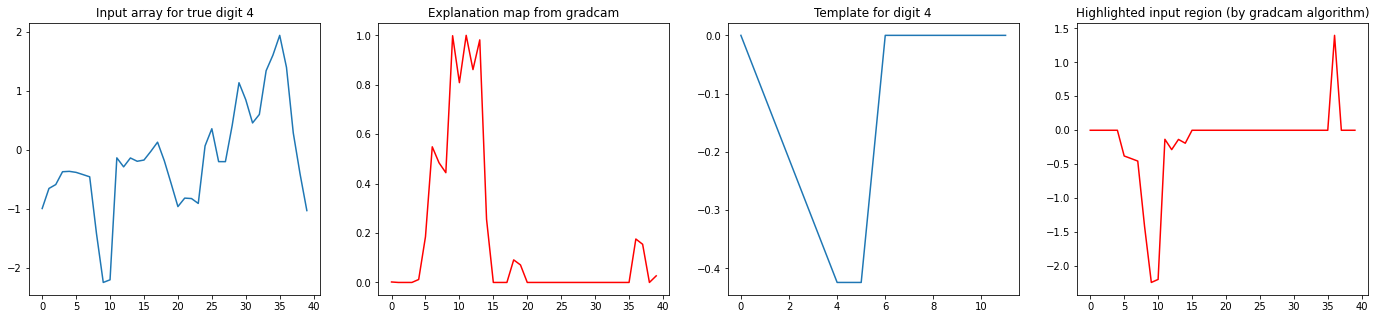

True digit:  4
Predicted digit:  4
Confidence score for the true digit:  0.5019803643226624
Confidence score for the predicted digit:  0.5019803643226624


In [34]:
mnistheatmaps(4, 'gradcam')

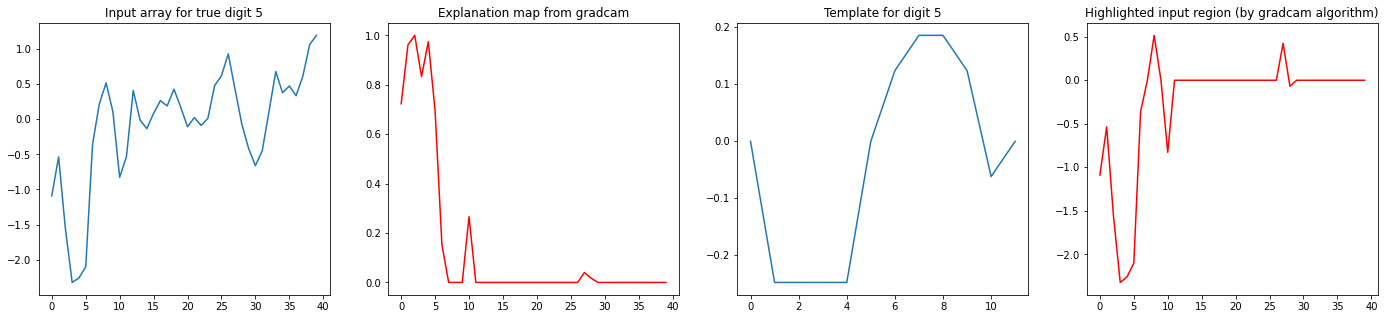

True digit:  5
Predicted digit:  4
Confidence score for the true digit:  0.36370599269866943
Confidence score for the predicted digit:  0.39674368500709534


In [35]:
mnistheatmaps(5, 'gradcam')

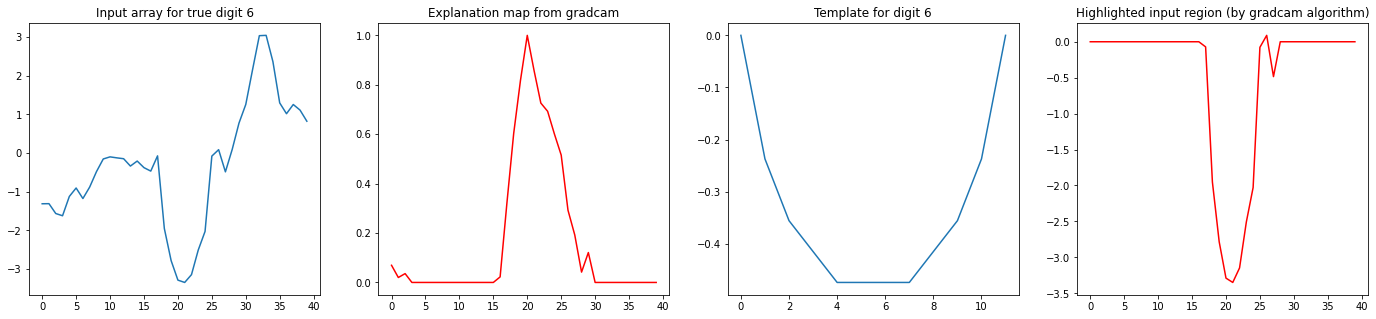

True digit:  6
Predicted digit:  6
Confidence score for the true digit:  0.9999997615814209
Confidence score for the predicted digit:  0.9999997615814209


In [36]:
mnistheatmaps(6, 'gradcam')

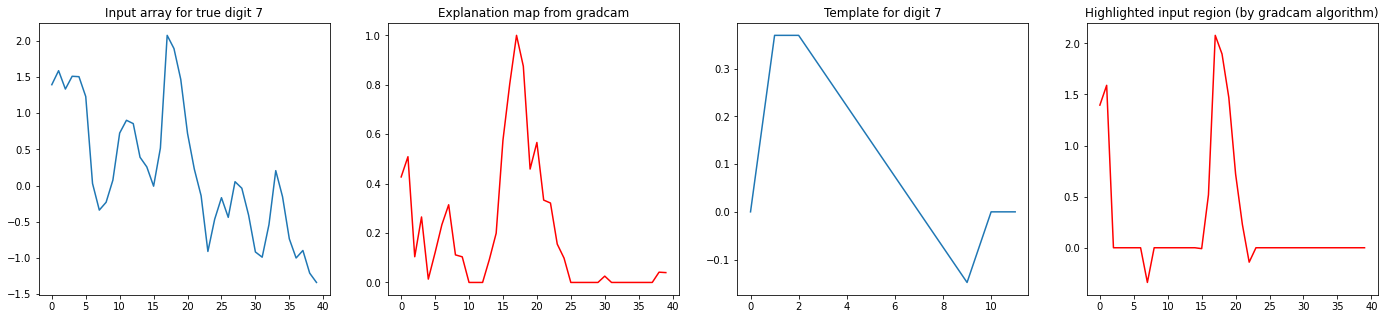

True digit:  7
Predicted digit:  7
Confidence score for the true digit:  0.9615776538848877
Confidence score for the predicted digit:  0.9615776538848877


In [37]:
mnistheatmaps(7, 'gradcam')

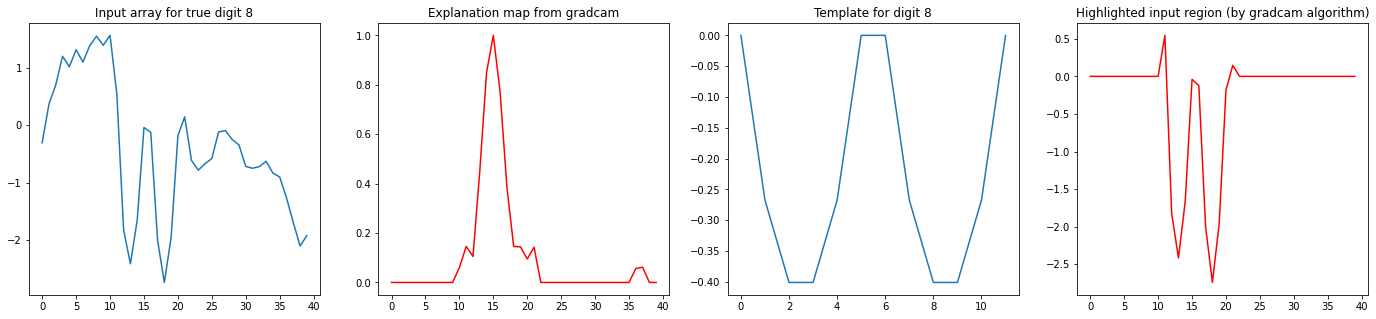

True digit:  8
Predicted digit:  8
Confidence score for the true digit:  0.9999715089797974
Confidence score for the predicted digit:  0.9999715089797974


In [38]:
mnistheatmaps(8, 'gradcam')

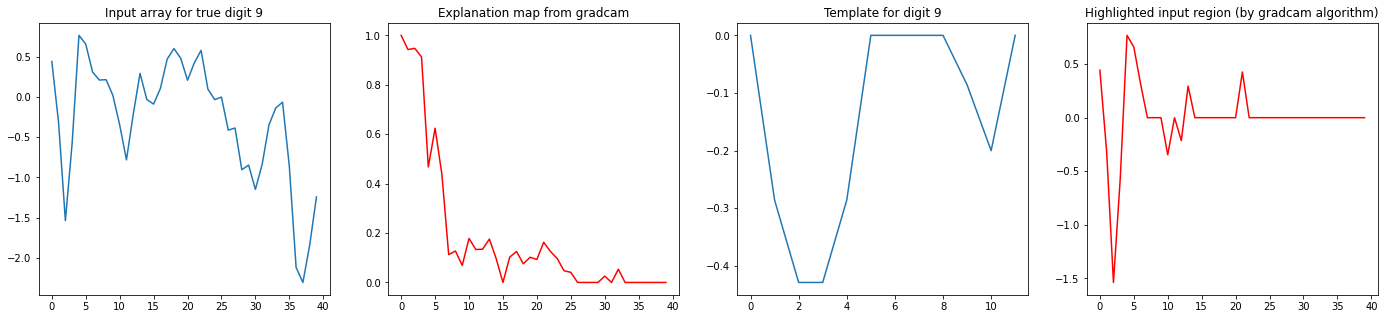

True digit:  9
Predicted digit:  5
Confidence score for the true digit:  0.000505736970808357
Confidence score for the predicted digit:  0.9722853899002075


In [39]:
mnistheatmaps(9, 'gradcam')

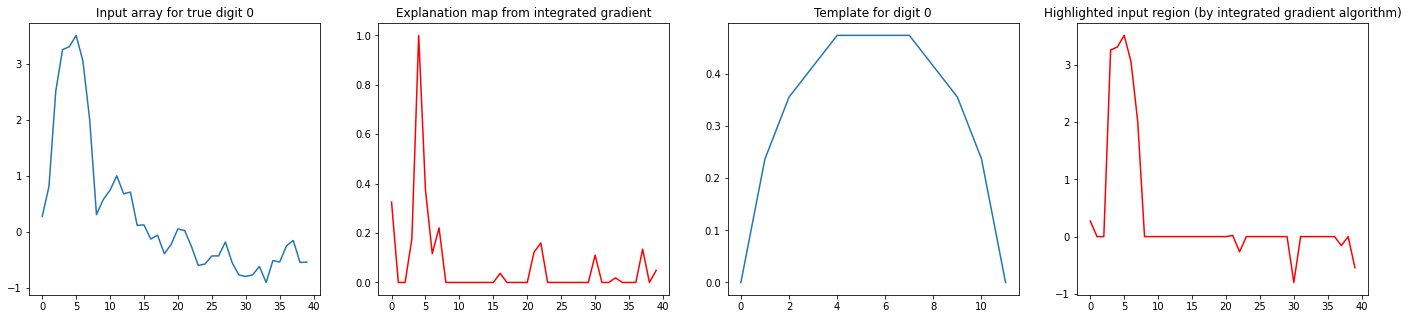

True digit:  0
Predicted digit:  0
Confidence score for the true digit:  0.9999557733535767
Confidence score for the predicted digit:  0.9999557733535767


In [40]:
mnistheatmaps(0, 'integrated gradient')

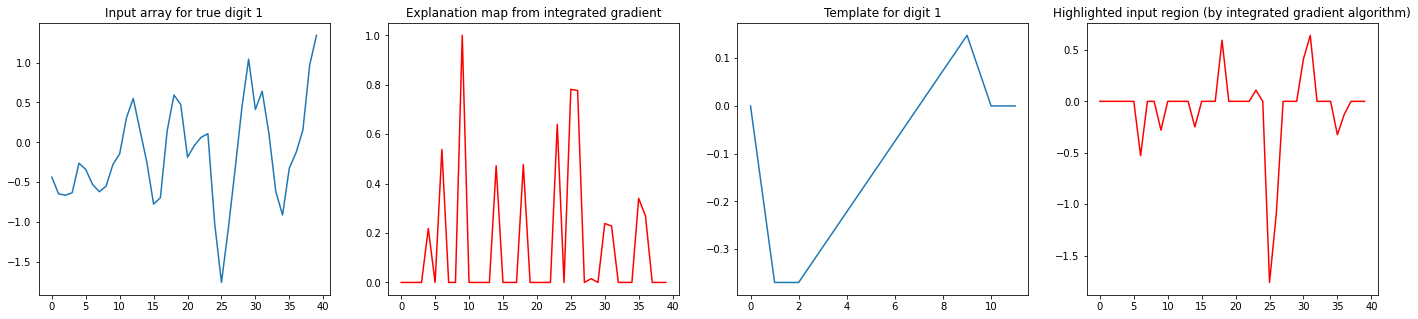

True digit:  1
Predicted digit:  1
Confidence score for the true digit:  0.7265156507492065
Confidence score for the predicted digit:  0.7265156507492065


In [41]:
mnistheatmaps(1, 'integrated gradient')

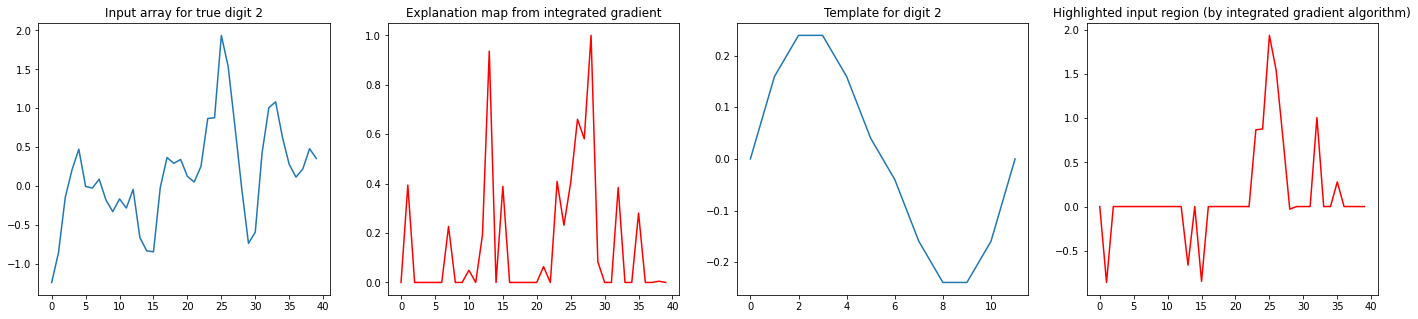

True digit:  2
Predicted digit:  7
Confidence score for the true digit:  0.30889150500297546
Confidence score for the predicted digit:  0.6897130608558655


In [42]:
mnistheatmaps(2, 'integrated gradient')

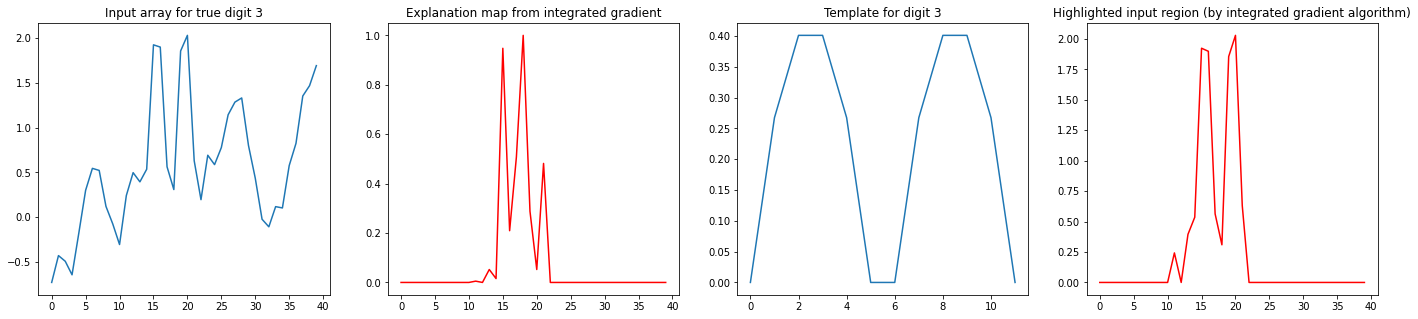

True digit:  3
Predicted digit:  3
Confidence score for the true digit:  0.8924388289451599
Confidence score for the predicted digit:  0.8924388289451599


In [43]:
mnistheatmaps(3, 'integrated gradient')

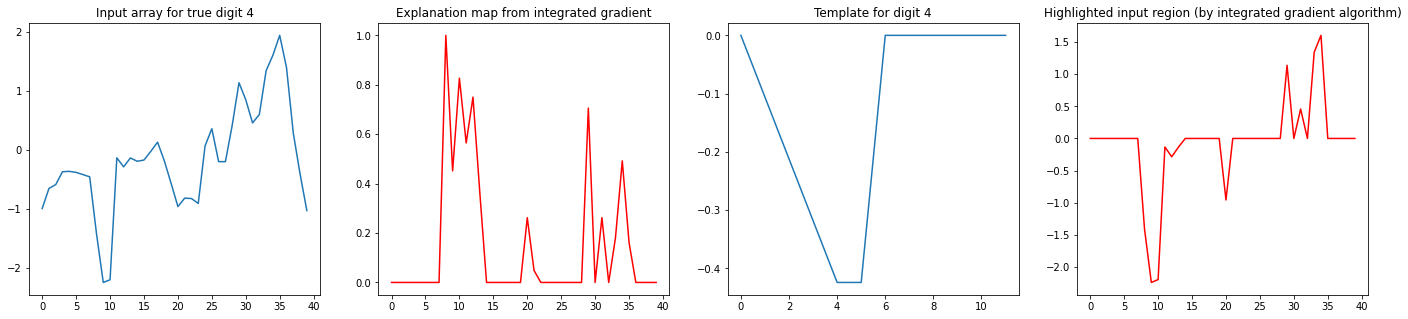

True digit:  4
Predicted digit:  4
Confidence score for the true digit:  0.5019803643226624
Confidence score for the predicted digit:  0.5019803643226624


In [44]:
mnistheatmaps(4, 'integrated gradient')

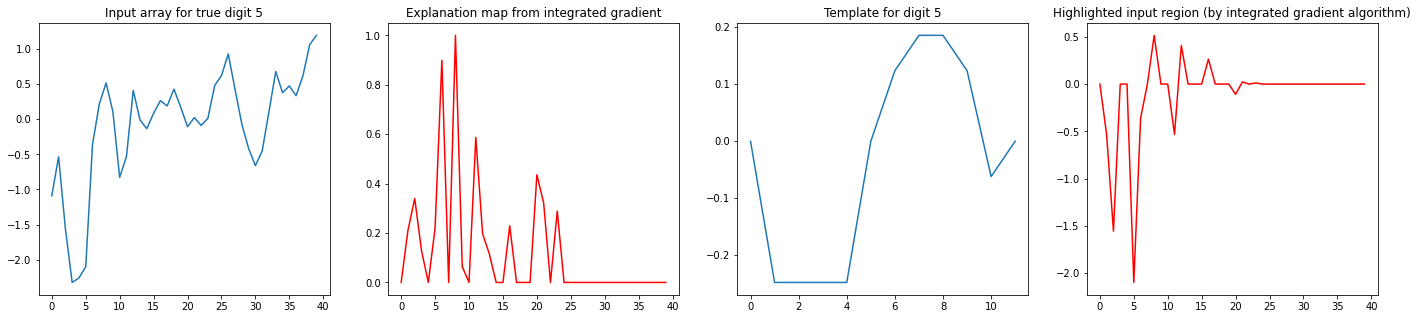

True digit:  5
Predicted digit:  4
Confidence score for the true digit:  0.36370599269866943
Confidence score for the predicted digit:  0.39674368500709534


In [45]:
mnistheatmaps(5, 'integrated gradient')

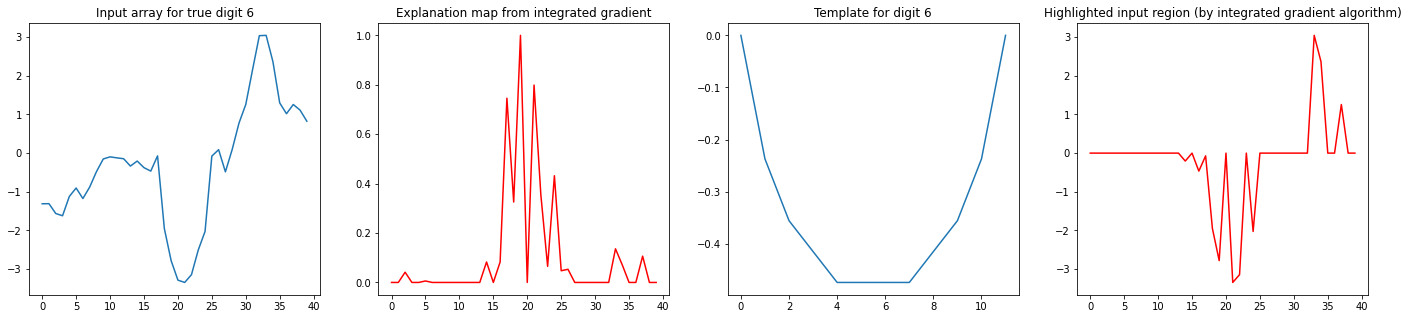

True digit:  6
Predicted digit:  6
Confidence score for the true digit:  0.9999997615814209
Confidence score for the predicted digit:  0.9999997615814209


In [46]:
mnistheatmaps(6, 'integrated gradient')

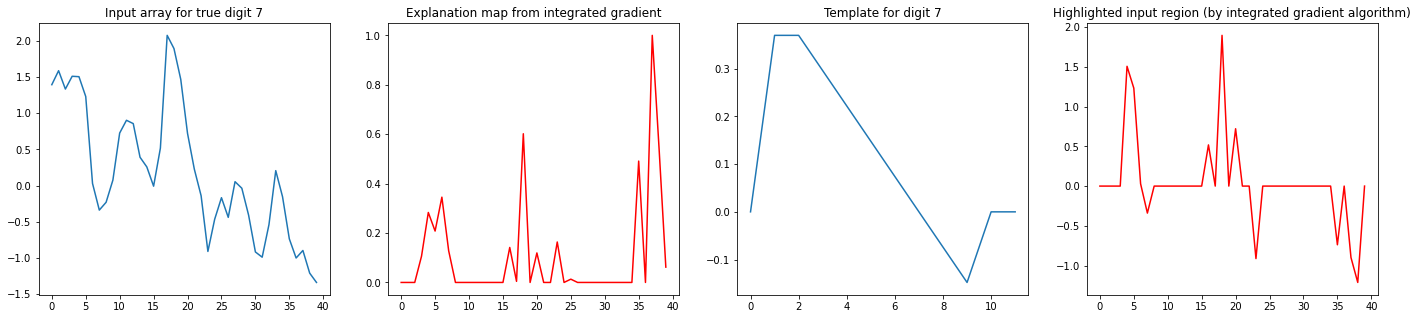

True digit:  7
Predicted digit:  7
Confidence score for the true digit:  0.9615776538848877
Confidence score for the predicted digit:  0.9615776538848877


In [47]:
mnistheatmaps(7, 'integrated gradient')

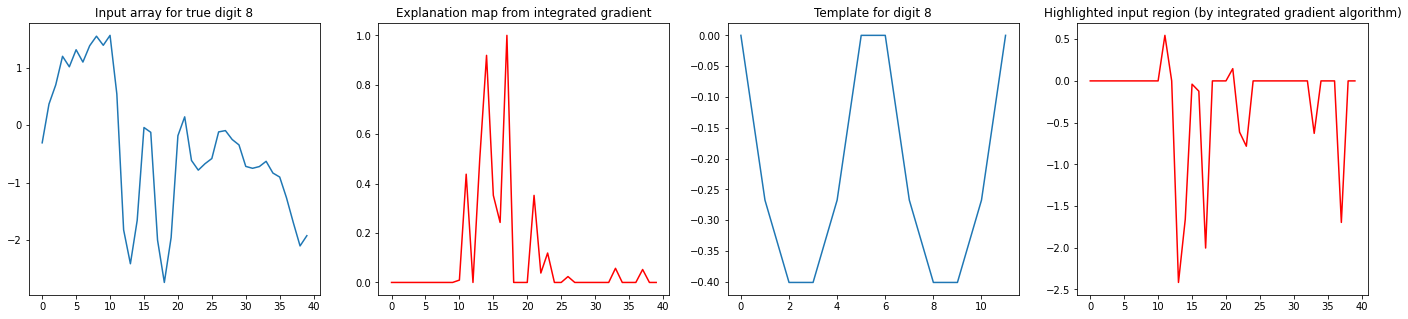

True digit:  8
Predicted digit:  8
Confidence score for the true digit:  0.9999715089797974
Confidence score for the predicted digit:  0.9999715089797974


In [48]:
mnistheatmaps(8, 'integrated gradient')

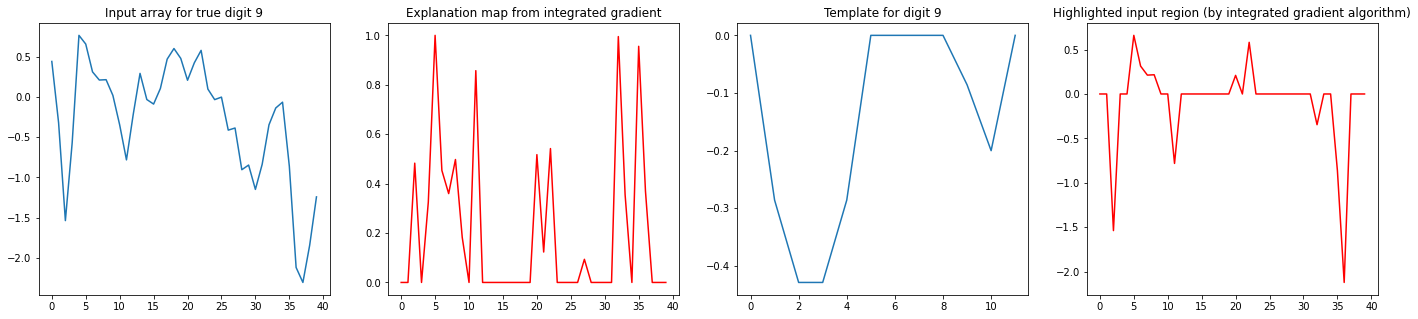

True digit:  9
Predicted digit:  5
Confidence score for the true digit:  0.000505736970808357
Confidence score for the predicted digit:  0.9722853899002075


In [49]:
mnistheatmaps(9, 'integrated gradient')

## Task 4 on MNIST1D

In [50]:
#Code taken from MNIST1D.ipynb with minor changes to make it specific to MNIST1D dataset
def calculate_drop_increase_mnist(images, exmap, class_index, frac=0.3):
  '''
  inputs:
      images: a 4-D image of size (1 x H x W x 3)
        containing an image in RGB format and of size (H x W)
      exmap: a given explanation map whose completeness is to be evaluated.
      class_index: The class to whom the explanation map is related to.
      frac: The fraction of top pixels selected.
  returns:
      a tuple with 2 values:
      (drop, increase)
      drop (float): drop rate (between 0 and 1)
      increase (boolean): "1" if increase happened
  '''
  predictions = model.predict(images)
  # Pre-processing image 
  img=images[0,:,0]
  # Getting the prediction for image
  Y=predictions[0][class_index]

  grad_array=np.reshape(exmap, (-1,))
  array_size=int(grad_array.shape[0]*frac)
  thr=np.flip(sorted(grad_array))[array_size]
  exmap1_msk=(exmap>thr)
  exmap1_thr=img*exmap1_msk
  exmap1_thr = np.expand_dims(np.expand_dims(exmap1_thr, axis=0), axis=-1)
  ex_predictions = model.predict(exmap1_thr)[0]
  O1=ex_predictions[class_index]
  etta=(Y-O1)/(Y+1e-100)
  return (etta*(etta>0), 1*(etta<0))

In [51]:
#Code taken from MNIST1D.ipynb with minor changes
drop_list_gradcam = [] #List containing the drop values for Grad CAM
increase_list_gradcam = [] #List containing the increase values for Grad CAM
drop_list_integratedgrad = [] #List containing the drop values for Integrated Gradient
increase_list_integratedgrad = [] #List containing the increase values for Integrated Gradient

for index in range(1000):
  input = np.expand_dims(np.expand_dims(data['x_test'][index], axis=0), axis=-1)
  prediction=model(input).numpy()
  explanation_map_gradcam = grad_cam(model, input, 'conv1d_2')
  drgc, irgc = calculate_drop_increase_mnist(input, explanation_map_gradcam, np.argmax(prediction[0])) #Obtaining drop and increase for gradcam for each image
  drop_list_gradcam.append(drgc)
  increase_list_gradcam.append(irgc)

  explanation_map_integratedgrad = explainerIG.explain((np.expand_dims(input, axis = -1), None), model,all_preds[index])[:,0]
  explanation_map_integratedgrad = ((explanation_map_integratedgrad - min(explanation_map_integratedgrad))/(max(explanation_map_integratedgrad) - min(explanation_map_integratedgrad)))
  drig, irig = calculate_drop_increase_mnist(input, explanation_map_integratedgrad, np.argmax(prediction[0])) #Obtaining drop and increase for integrated gradient for each image
  drop_list_integratedgrad.append(drig)
  increase_list_integratedgrad.append(irig)

print('Drop rate of Grad CAM on MNIST1D: ', sum(drop_list_gradcam)/1000)
print('Increase rate of Grad CAM on MNIST1D: ', sum(increase_list_gradcam)/1000)
print('Drop rate of Integrated gradient on MNIST1D: ', sum(drop_list_integratedgrad)/1000)
print('Increase rate of Integrated gradient on MNIST1D: ', sum(increase_list_integratedgrad)/1000)

/content/drive/My Drive/ECE1512/Project1/xai_utils.py:363: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()


Drop rate of Grad CAM on MNIST1D:  0.4106280361887135
Increase rate of Grad CAM on MNIST1D:  0.301
Drop rate of Integrated gradient on MNIST1D:  0.4091846308101215
Increase rate of Integrated gradient on MNIST1D:  0.173


In [52]:
np.where(np.array(drop_list_gradcam) == max(drop_list_gradcam))[0] # Failure cases of Grad CAM

array([  1,   2, 141, 157, 159, 169, 172, 211, 214, 219, 228, 271, 282,
       315, 349, 353, 354, 379, 380, 389, 405, 419, 430, 440, 486, 537,
       538, 555, 571, 593, 601, 607, 674, 692, 705, 768, 770, 786, 844,
       863, 871, 916, 950, 982, 984, 986])

In [53]:
np.where(np.array(increase_list_gradcam) == max(increase_list_gradcam))[0] #Success cases of Grad CAM

array([  5,   6,   8,   9,  12,  13,  14,  15,  16,  22,  24,  25,  27,
        29,  38,  40,  43,  44,  45,  47,  49,  55,  57,  62,  66,  69,
        71,  74,  78,  81,  82,  86,  89,  98,  99, 100, 102, 103, 114,
       120, 124, 131, 133, 134, 136, 137, 140, 143, 146, 149, 150, 151,
       158, 161, 163, 165, 170, 177, 181, 182, 183, 185, 187, 190, 191,
       194, 195, 198, 200, 202, 212, 213, 215, 217, 218, 220, 229, 231,
       232, 235, 239, 241, 244, 246, 252, 254, 255, 258, 262, 264, 268,
       276, 291, 306, 310, 311, 312, 320, 322, 325, 326, 328, 329, 331,
       335, 337, 340, 352, 356, 358, 365, 367, 370, 374, 386, 397, 403,
       404, 406, 407, 409, 411, 414, 415, 416, 417, 421, 424, 425, 427,
       428, 436, 443, 445, 452, 454, 455, 456, 461, 466, 469, 471, 474,
       476, 479, 483, 485, 490, 494, 496, 499, 503, 504, 508, 511, 512,
       514, 517, 519, 521, 522, 525, 529, 530, 533, 535, 548, 549, 552,
       558, 564, 567, 570, 572, 573, 575, 577, 580, 583, 585, 58

In [54]:
np.where(np.array(drop_list_integratedgrad) == max(drop_list_integratedgrad)) # Failure cases of Integrated Gradient

(array([ 15,  31,  50,  70,  80,  81, 100, 147, 156, 177, 219, 250, 269,
        282, 283, 310, 367, 420, 439, 468, 483, 485, 491, 512, 520, 525,
        535, 580, 586, 596, 642, 675, 689, 716, 733, 756, 774, 822, 834,
        863, 877, 881, 892, 963, 981, 982, 984, 985]),)

In [55]:
np.where(np.array(increase_list_integratedgrad) == max(increase_list_integratedgrad))[0] #Success cases of Integrated Gradient

array([  4,   5,  12,  14,  25,  33,  34,  55,  58,  61,  65,  71,  84,
        90, 116, 120, 130, 136, 138, 139, 144, 151, 162, 166, 170, 181,
       193, 194, 209, 212, 229, 232, 244, 254, 255, 258, 260, 262, 264,
       274, 288, 293, 301, 303, 304, 305, 306, 312, 328, 332, 338, 340,
       356, 358, 359, 361, 368, 369, 372, 374, 388, 395, 396, 401, 403,
       404, 406, 415, 416, 423, 425, 426, 428, 431, 443, 445, 446, 447,
       449, 455, 461, 466, 471, 478, 497, 499, 509, 511, 517, 524, 531,
       532, 541, 542, 546, 552, 558, 564, 566, 567, 573, 577, 581, 583,
       604, 613, 614, 620, 624, 627, 636, 644, 652, 654, 661, 665, 666,
       687, 690, 693, 695, 701, 702, 708, 712, 713, 717, 720, 721, 723,
       725, 737, 748, 758, 769, 775, 776, 780, 797, 798, 799, 803, 805,
       812, 821, 824, 827, 838, 840, 852, 853, 855, 856, 857, 858, 872,
       875, 882, 898, 907, 914, 917, 924, 927, 929, 938, 945, 947, 952,
       956, 983, 989, 990])

In [56]:
def mnistheatmaps(index, method):
  input = data['x_test'][index]
  true = data['y_test'][index]
  pred = all_preds[index]
  if method == "gradcam":
    explanation = grad_cam(model, np.expand_dims(np.expand_dims(input, axis=0), axis=-1), 'conv1d_2')

  else:
    inp = np.expand_dims(np.expand_dims(np.expand_dims(input, axis=0), axis=-1), axis = -1)
    explanation = explainerIG.explain((inp, None), model,pred)[:,0]
    explanation = ((explanation - min(explanation))/(max(explanation) - min(explanation)))

  threshold = np.sort(explanation)[-12]
  #Code taken from MNIST1D.ipynb
  plt.figure(figsize=(24,5))

  plt.subplot(1,4,1)
  plt.plot(input)
  plt.title('Input array for true digit '+ str(true))

  plt.subplot(1,4,2)
  plt.plot(explanation, 'r')
  plt.title('Explanation map from '+ str(method))

  plt.subplot(1,4,3)
  plt.plot(data['templates']['x'][true])
  plt.title('Template for digit '+ str(true))

  plt.subplot(1,4,4)
  plt.plot((input*(explanation>threshold)), 'r')
  plt.title('Highlighted input region (by '+ str(method) +' algorithm)')
  plt.show()
  print('True digit: ',true)
  print('Predicted digit: ',pred)

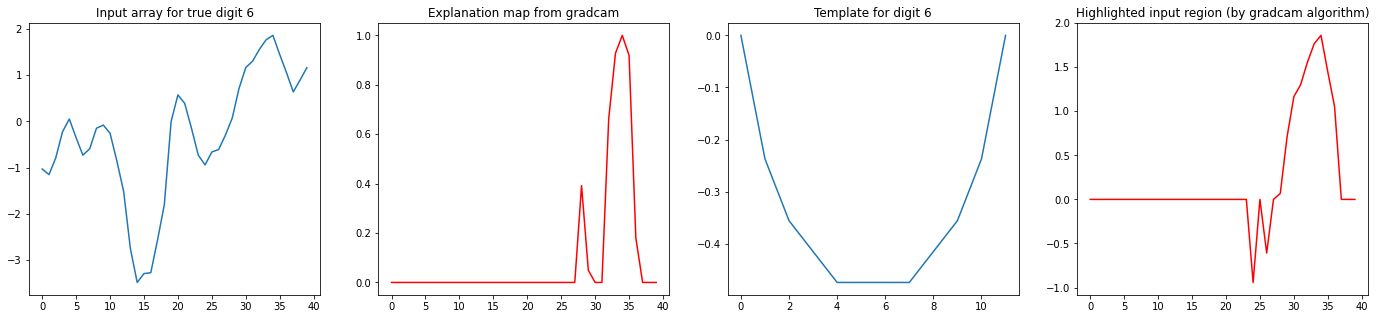

True digit:  6
Predicted digit:  6


In [57]:
mnistheatmaps(157, "gradcam") #Failure case grad cam

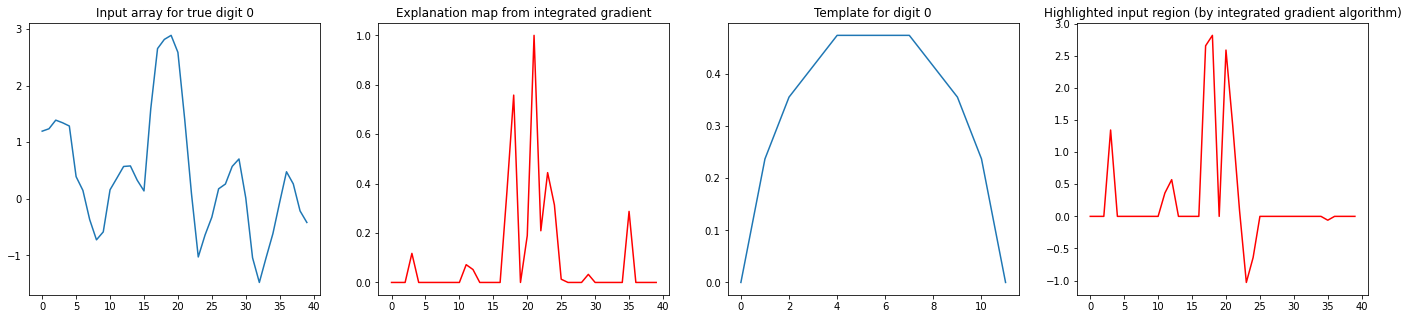

True digit:  0
Predicted digit:  0


In [58]:
mnistheatmaps(31, "integrated gradient") #Failure Case int grad

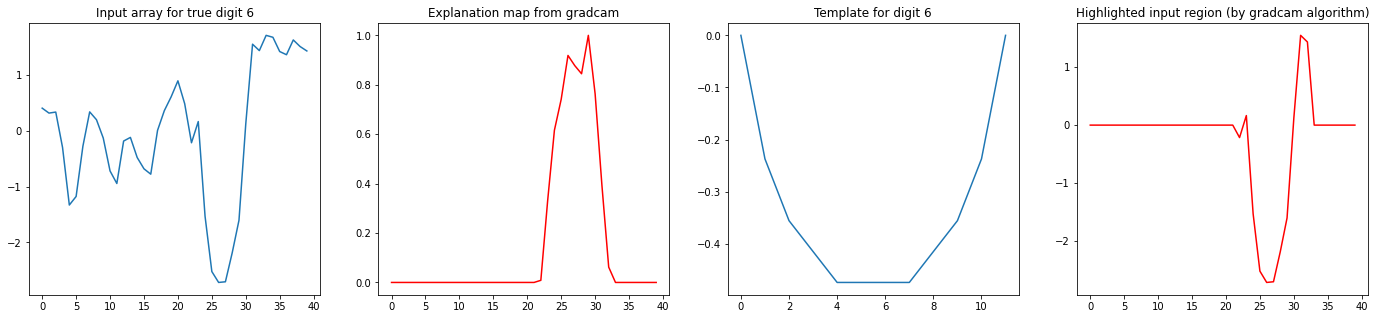

True digit:  6
Predicted digit:  6


In [59]:
mnistheatmaps(100, "gradcam") #Success case grad cam

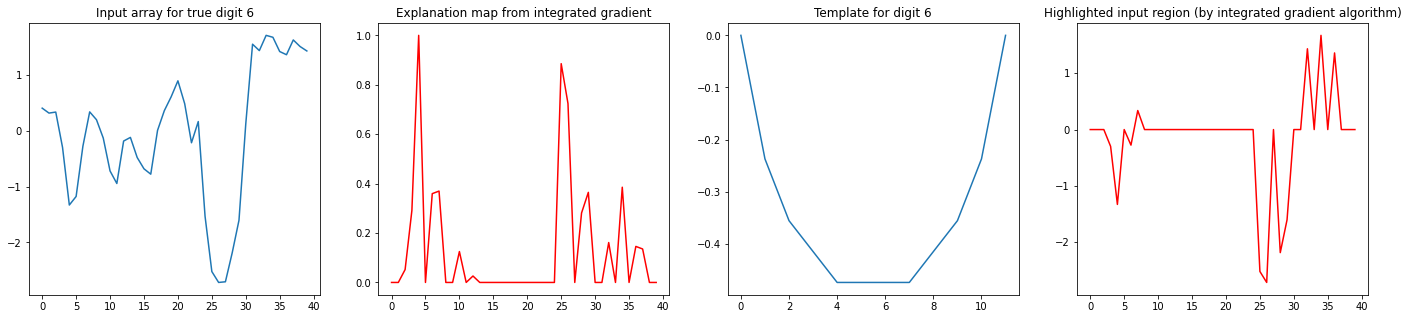

True digit:  6
Predicted digit:  6


In [60]:
mnistheatmaps(100, "integrated gradient") #Failure Case int grad

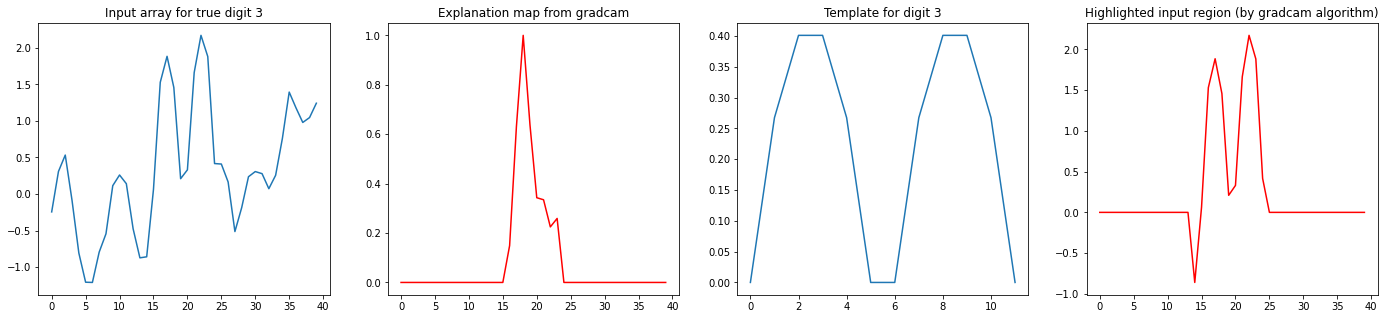

True digit:  3
Predicted digit:  3


In [61]:
mnistheatmaps(33, "gradcam") #Success case grad cam but drop rate is high because of the dip to the left of the M-shape

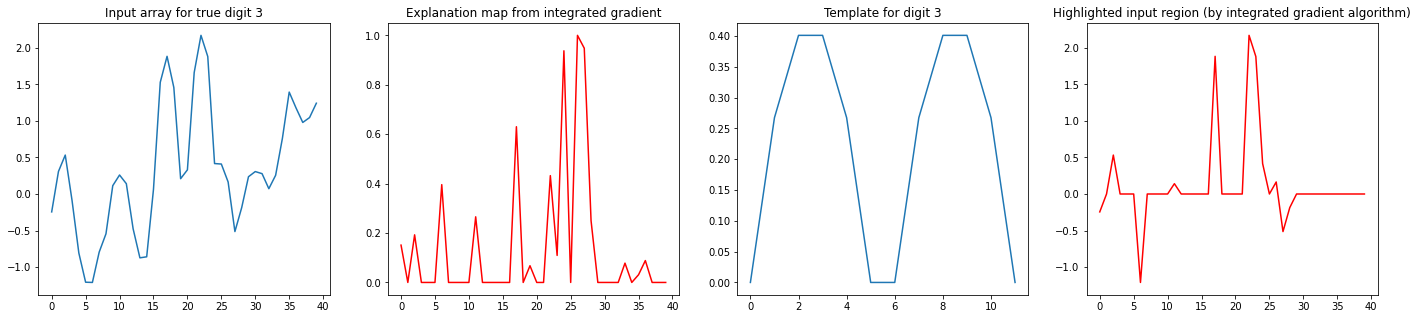

True digit:  3
Predicted digit:  3


In [62]:
mnistheatmaps(33, "integrated gradient") #Success Case int grad

## Task 3

### Q1

In [ ]:
# Importing xai_utils
os.chdir(r'/content/drive/My Drive/project_a_supp')
from xai_utils import *

In [ ]:
#Load model
os.chdir(r'/content/drive/My Drive/project_a_supp/models')
model=load_model('HMT.h5')

In [ ]:
#Load test dataset
#Code from HMT.ipynb 'Dataset loader'
test_dir = '/content/drive/My Drive/project_a_supp/hmt_dataset/HMT_test'
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 496 images belonging to 8 classes.


In [ ]:
scores = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size + 1, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

16/16 [==============================] - 1s 88ms/step - loss: 0.5554 - accuracy: 0.8347
Test loss: 0.555415689945221
Test accuracy: 0.8346773982048035


16/16 [==============================] - 2s 97ms/step


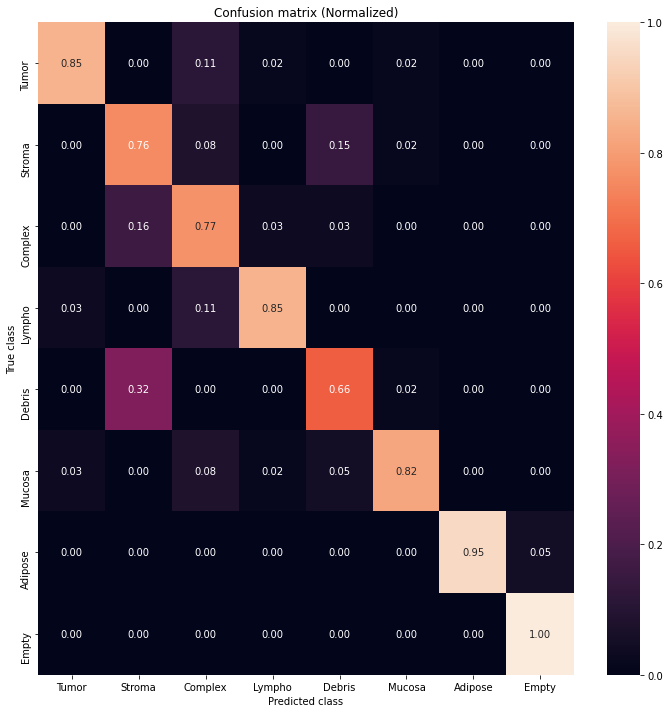

In [ ]:
num_classes = 8
nb_samples = 496
bs = 32

y_test = pd.get_dummies(pd.Series(test_generator.classes))
y_pred =  model.predict(test_generator,steps = nb_samples//bs + 1, verbose=1)
y_test = y_test.to_numpy()
y_preds = [np.argmax(i) for i in y_pred]
y_preds = np.asarray(y_preds)
y_tests = [np.argmax(i) for i in y_test]
y_tests = np.asarray(y_tests)

cnf_matrix = confusion_matrix(test_generator.classes, y_preds,normalize='true')

LABELS = ["Tumor","Stroma","Complex","Lympho","Debris","Mucosa","Adipose","Empty"]

plt.figure(figsize=(12, 12))
sns.heatmap(cnf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".2f");
plt.title("Confusion matrix (Normalized)")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

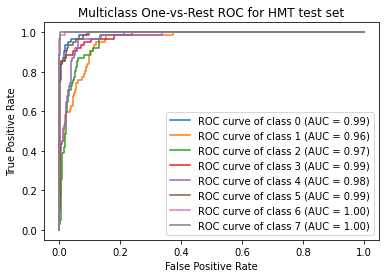

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.title("Multiclass One-vs-Rest ROC for HMT test set")
plt.legend(loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
print("Precision, recall, f1 score for each class is shown through Classification report", classification_report(test_generator.classes, y_preds), sep = '\n')

Precision, recall, f1 score for each class is shown through Classification report
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        62
           1       0.61      0.76      0.68        62
           2       0.67      0.77      0.72        62
           3       0.93      0.85      0.89        62
           4       0.75      0.66      0.70        62
           5       0.94      0.82      0.88        62
           6       1.00      0.95      0.98        62
           7       0.95      1.00      0.98        62

    accuracy                           0.83       496
   macro avg       0.85      0.83      0.84       496
weighted avg       0.85      0.83      0.84       496



### Q2

In [ ]:
#Change Batch Size to 62 (images per class) and print model architecture
bs = 62
test_generator.batch_size = bs
model.summary()
LABELS = ["Tumor","Stroma","Complex","Lympho","Debris","Mucosa","Adipose","Empty"]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

#Saliency Heatmaps

In [ ]:
test_generator.reset()

In [ ]:
# Heatmap code modified from HMT.ipynb
# Using tf_explain API for intgrad methods
def dispheatmaps(model,image,label):
    img = image.squeeze()

    explanation_map_GradCAM = grad_cam(model, np.expand_dims(image, axis=0), 'max_pooling2d_1')
    explanation_map_GradCAM -= explanation_map_GradCAM.min()
    explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

    explanation_map_IntGrad = explainerIG.explain((np.array([image]), None), model, label).astype('float32')
    explanation_map_IntGrad -= explanation_map_IntGrad.min()
    explanation_map_IntGrad /= explanation_map_IntGrad.max()+10e-30

    nn = 3
    fig = plt.figure(figsize=(10,10))
    a = fig.add_subplot(1, nn, 1)
    plt.imshow(img)
    a.set_title("original",fontsize=10)
    plt.axis('off')
    
    a = fig.add_subplot(1, nn, 2)
    plt.imshow(explanation_map_GradCAM,cmap='plasma', interpolation='nearest')
    a.set_title("gradCAM",fontsize=10)
    plt.axis('off')
    
    a = fig.add_subplot(1, nn, 3)
    plt.imshow(explanation_map_IntGrad,cmap='plasma', interpolation='nearest')
    a.set_title("IntGrad",fontsize=10)
    plt.axis('off')
    
    plt.show()

In [ ]:
# code modified from HMT.ipynb
# code to search for misclassifications (run again to proceed to next class)
image_batch,label_batch=test_generator.next()
for index in range (62):
  prediction=model(image_batch)
  print('True label: '+LABELS[np.argmax(label_batch[index])])
  print('Predicted_label: '+LABELS[np.argmax(prediction[index])])

True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Complex
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Lympho
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Mucosa
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Tumor
True label: Tumor
Predicted_label: Complex
True label: Tumor
Predicted_label: Tumor
True label

Misclassifications

True label: Tumor
Predicted_label: Complex
Confidence score for the correct label: 0.018222176


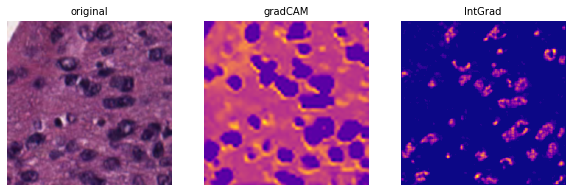

In [ ]:
# code modified from HMT.ipynb
index = 4

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Stroma
Predicted_label: Complex
Confidence score for the correct label: 0.29692554


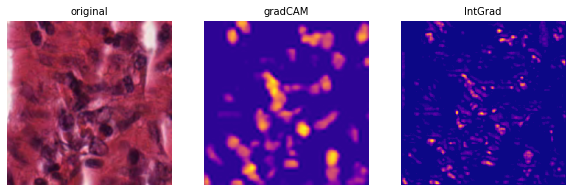

In [ ]:
# code modified from HMT.ipynb
index = 2

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Stroma
Predicted_label: Debris
Confidence score for the correct label: 0.4158614


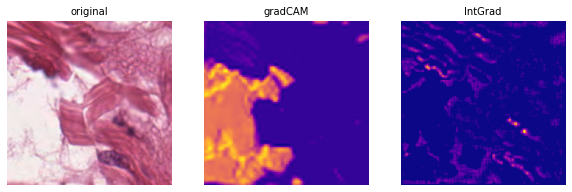

In [ ]:
# code modified from HMT.ipynb
index = 16

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Complex
Predicted_label: Stroma
Confidence score for the correct label: 0.39964104


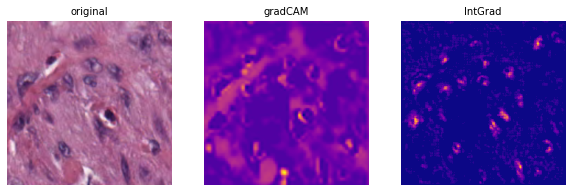

In [ ]:
# code modified from HMT.ipynb
index = 13

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Lympho
Predicted_label: Complex
Confidence score for the correct label: 0.10232981


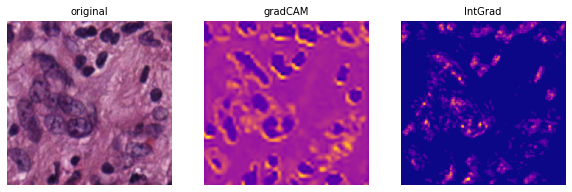

In [ ]:
# code modified from HMT.ipynb
index = 0

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Debris
Predicted_label: Stroma
Confidence score for the correct label: 0.3244412


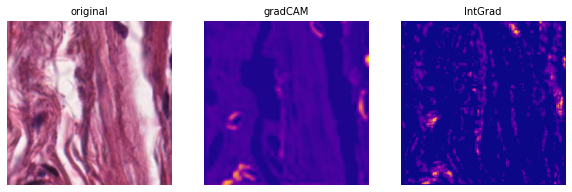

In [ ]:
# code modified from HMT.ipynb
index = 0

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Mucosa
Predicted_label: Complex
Confidence score for the correct label: 0.4661436


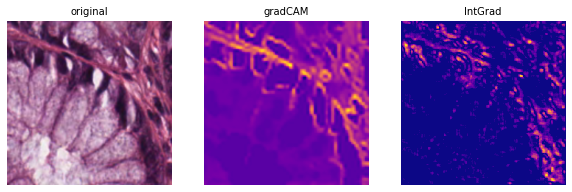

In [ ]:
# code modified from HMT.ipynb
index = 9

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

Correct Classifications

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.96135336


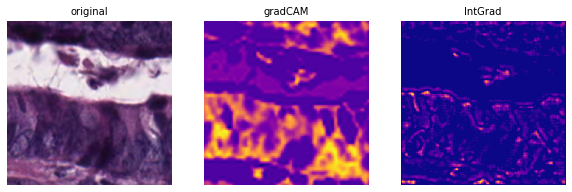

In [ ]:
# code modified from HMT.ipynb
index = 9

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Stroma
Predicted_label: Stroma
Confidence score for the correct label: 0.6072778


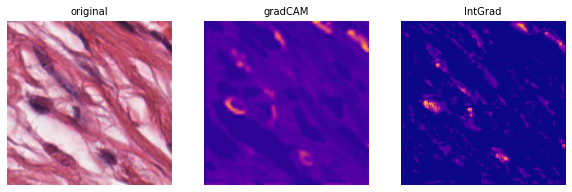

In [ ]:
index = 9

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Complex
Predicted_label: Complex
Confidence score for the correct label: 0.6558045


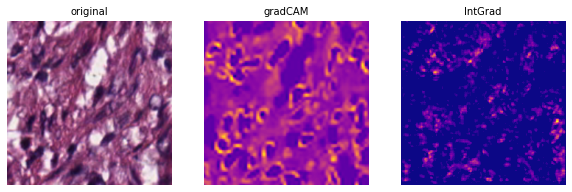

In [ ]:
index = 9

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Lympho
Predicted_label: Lympho
Confidence score for the correct label: 0.99998736


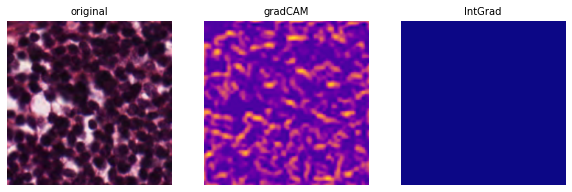

In [ ]:
# Interesting case where IntGrad is 0. Try to debug
index = 9

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Lympho
Predicted_label: Lympho
Confidence score for the correct label: 0.76709276


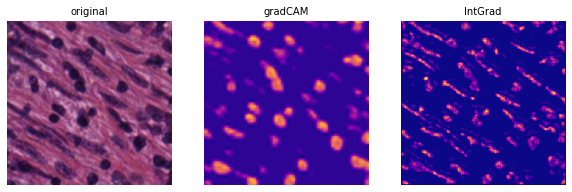

In [ ]:
index = 1

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Debris
Predicted_label: Debris
Confidence score for the correct label: 0.91610295


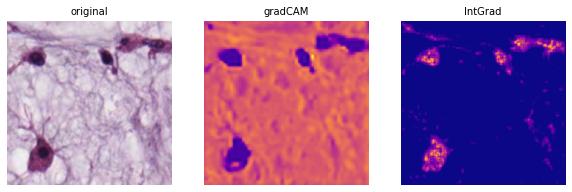

In [ ]:
index = 4

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Mucosa
Predicted_label: Mucosa
Confidence score for the correct label: 0.92712176


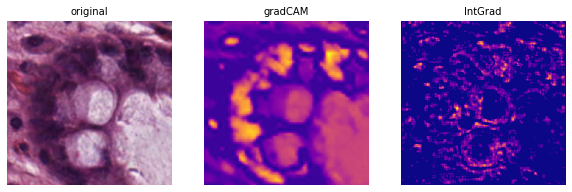

In [ ]:
index = 0

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Adipose
Predicted_label: Adipose
Confidence score for the correct label: 0.97052807


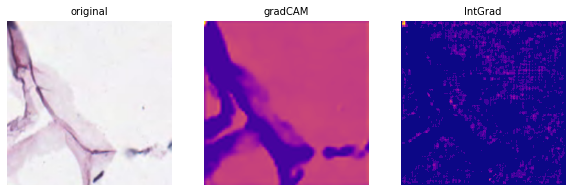

In [ ]:
index = 9

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

True label: Empty
Predicted_label: Empty
Confidence score for the correct label: 0.9044203


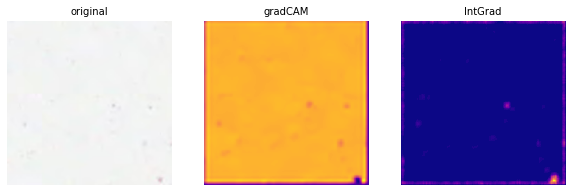

In [ ]:
index = 9

image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmaps(model,image_batch[index],np.argmax(prediction[index]))

## Task 4 on HMT

In [ ]:
#code modified from HMT.ipynb
#modified such that original and new predictions are not returned
def calculate_drop_increase(images, model, exmap, class_index, frac=0.9):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 3 values:
        (drop, increase, rawdrop)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        rawdrop (float)
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), etta)

In [ ]:
#code modified from HMT.ipynb
test_generator.reset()
nclasses = 8
imagesperclass = 62
drop_rate_gradcam = 0.
increase_rate_gradcam = 0.
drop_rate_intgrad = 0.
increase_rate_intgrad = 0.
# Keep track of drops to find interesting examples
gradcamdrops = {}
intgraddrops = {}
differencedrops = {}

for i in range(nclasses):
    image_batch,label_batch=test_generator.next()
    for index in range(imagesperclass):
        prediction=model(image_batch)
        
        explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
        explanation_map_GradCAM -= explanation_map_GradCAM.min()
        explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

        explanation_map_IntGrad = explainerIG.explain((np.array([image_batch[index]]), None), model, class_index=np.argmax(prediction[index])).astype('float32')
        explanation_map_IntGrad -= explanation_map_IntGrad.min()
        explanation_map_IntGrad /= explanation_map_IntGrad.max()+10e-30

        drgc, irgc, gradcamdrops[i,index] = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_GradCAM, class_index=np.argmax(prediction[index]), frac=0.9)
        drig, irig, intgraddrops[i,index] = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_IntGrad, class_index=np.argmax(prediction[index]), frac=0.9)

        differencedrops[i,index] = gradcamdrops[i,index]-intgraddrops[i,index]

        drop_rate_gradcam += drgc
        increase_rate_gradcam += irgc
        drop_rate_intgrad += drig
        increase_rate_intgrad += irig

drop_rate_gradcam /= (nclasses*imagesperclass)
increase_rate_gradcam /= (nclasses*imagesperclass)
drop_rate_intgrad /= (nclasses*imagesperclass)
increase_rate_intgrad /= (nclasses*imagesperclass)

print('Drop rate of Grad CAM on HMT: ', drop_rate_gradcam)
print('Increase rate of Grad CAM on HMT: ', increase_rate_gradcam)
print('Drop rate of Integrated gradient on HMT: ', drop_rate_intgrad)
print('Increase rate of Integrated gradient on HMT: ', increase_rate_intgrad)

Drop rate of Grad CAM on HMT:  0.5029112231523045
Increase rate of Grad CAM on HMT:  0.2862903225806452
Drop rate of Integrated gradient on HMT:  0.8850806393334752
Increase rate of Integrated gradient on HMT:  0.11491935483870967


In [ ]:
sorted(differencedrops.items(), key=lambda x:x[1])

[((1, 4), -1.9947692038736173),
 ((6, 5), -1.8650038400963311),
 ((5, 55), -1.7949142644411689),
 ((6, 13), -1.7532854214072677),
 ((5, 39), -1.5990778576973237),
 ((2, 5), -1.5733162055303789),
 ((1, 2), -1.531788673402804),
 ((2, 20), -1.5249690401375466),
 ((2, 17), -1.5034937022133705),
 ((1, 59), -1.4431284583379516),
 ((1, 28), -1.436241818758385),
 ((2, 30), -1.4198440151675222),
 ((2, 36), -1.3492819525016897),
 ((4, 19), -1.3380297368690242),
 ((6, 53), -1.3318276687224264),
 ((3, 59), -1.321358890427472),
 ((2, 3), -1.3200723446662104),
 ((0, 26), -1.3195566498991191),
 ((2, 15), -1.3108113863439603),
 ((2, 8), -1.275606679246481),
 ((6, 60), -1.2700040739437948),
 ((6, 16), -1.265004820444338),
 ((4, 10), -1.2414227004850757),
 ((2, 40), -1.2379617604526298),
 ((6, 54), -1.2339303721310102),
 ((6, 14), -1.2290183491976174),
 ((6, 52), -1.2288365093941842),
 ((6, 51), -1.2003150457282308),
 ((2, 43), -1.1797968277376358),
 ((6, 21), -1.1646720374281374),
 ((1, 27), -1.1535898

In [ ]:
sorted(gradcamdrops.items(), key=lambda x:x[1])

[((3, 60), -1.1710540646571483),
 ((1, 4), -0.9947692038736172),
 ((6, 5), -0.8650038400963311),
 ((0, 13), -0.8173524980568827),
 ((5, 55), -0.7949142644411687),
 ((6, 13), -0.7532854214072678),
 ((2, 37), -0.65036540797298),
 ((5, 39), -0.5990778576973236),
 ((5, 33), -0.5879012024189504),
 ((2, 5), -0.5733162055303789),
 ((3, 42), -0.5357413841522195),
 ((1, 2), -0.5317886734028039),
 ((2, 20), -0.5249690401375466),
 ((2, 17), -0.5034937022133705),
 ((1, 59), -0.44312845833795156),
 ((1, 28), -0.4362418187583849),
 ((2, 30), -0.41984401516752234),
 ((3, 52), -0.3682670028566336),
 ((2, 36), -0.34928195250168964),
 ((4, 19), -0.3380297368690242),
 ((6, 53), -0.3318276687224265),
 ((3, 59), -0.32135889042747207),
 ((2, 3), -0.3200723446662103),
 ((0, 26), -0.3195566498991192),
 ((2, 15), -0.31081138634396027),
 ((3, 1), -0.2966300467284564),
 ((2, 8), -0.275606679246481),
 ((6, 60), -0.27000407394379483),
 ((6, 16), -0.2650048204443381),
 ((4, 10), -0.24142270048507564),
 ((2, 40), -0

In [ ]:
sorted(intgraddrops.items(), key=lambda x:x[1])

[((3, 60), -1.2135345925790617),
 ((0, 13), -0.8176804498888084),
 ((2, 37), -0.6528120351002082),
 ((5, 33), -0.5933246284245188),
 ((3, 42), -0.553932824877721),
 ((3, 52), -0.37167599528418355),
 ((3, 1), -0.3036240078808523),
 ((3, 24), -0.1852140708396657),
 ((3, 55), -0.1342073813052418),
 ((2, 42), -0.12380746452553187),
 ((3, 39), -0.10739552071968628),
 ((3, 11), -0.07172239036051237),
 ((3, 27), -0.07031687848911505),
 ((3, 56), -0.06514142036894931),
 ((3, 16), -0.06061336509885413),
 ((3, 36), -0.024549982733040595),
 ((3, 28), -0.021485694023084298),
 ((3, 47), -0.019253478885983718),
 ((3, 35), -0.018038044542136242),
 ((3, 21), -0.017619942163136542),
 ((3, 46), -0.014906170631133813),
 ((3, 6), -0.012609139139199557),
 ((3, 45), -0.011004058909751627),
 ((3, 33), -0.006365508302513524),
 ((3, 15), -0.005928650418998735),
 ((3, 12), -0.005861043524628775),
 ((3, 43), -0.004454520194776819),
 ((3, 17), -0.004348510096517289),
 ((3, 20), -0.004287247305408111),
 ((3, 50), 

In [ ]:
# Heatmap code modified from HMT.ipynb
# Using tf_explain API for backprop methods
def dispheatmapsanddrops(model,image,label):
    img = image.squeeze()

    explanation_map_GradCAM = grad_cam(model, np.expand_dims(image, axis=0), 'max_pooling2d_1')
    explanation_map_GradCAM -= explanation_map_GradCAM.min()
    explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

    explanation_map_IntGrad = explainerIG.explain((np.array([image]), None), model, label).astype('float32')
    explanation_map_IntGrad -= explanation_map_IntGrad.min()
    explanation_map_IntGrad /= explanation_map_IntGrad.max()+10e-30

    #print(explanation_map_IntGrad)

    _, _, drop1 = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_GradCAM, label, frac=0.9)
    _, _, drop2 = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_IntGrad, label, frac=0.9)
    print('Normalized decrease in predicion score of Grad-CAM: ', drop1)
    print('Normalized decrease in predicion score of integrated gradients: ', drop2)

    nn = 3
    fig = plt.figure(figsize=(10,10))
    a = fig.add_subplot(1, nn, 1)
    plt.imshow(img)
    a.set_title("original",fontsize=10)
    plt.axis('off')
    
    a = fig.add_subplot(1, nn, 2)
    plt.imshow(explanation_map_GradCAM,cmap='plasma', interpolation='nearest')
    a.set_title("gradCAM",fontsize=10)
    plt.axis('off')
    
    a = fig.add_subplot(1, nn, 3)
    plt.imshow(explanation_map_IntGrad,cmap='plasma', interpolation='nearest')
    a.set_title("IntGrad",fontsize=10)
    plt.axis('off')
    
    plt.show()

In [ ]:
test_generator.reset()

True label: Tumor
Predicted_label: Complex
Confidence score for the correct label: 0.018222183
Normalized decrease in predicion score of Grad-CAM:  0.9982978508582955
Normalized decrease in predicion score of integrated gradients:  1.0


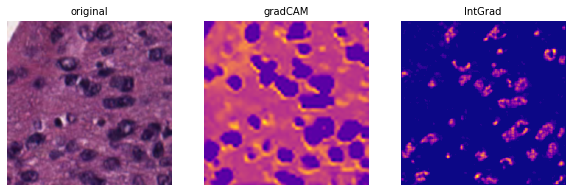

In [ ]:
index = 4
# grad-CAM and intgrad are inverted
image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmapsanddrops(model,image_batch[index],np.argmax(prediction[index]))

True label: Debris
Predicted_label: Debris
Confidence score for the correct label: 0.916103
Normalized decrease in predicion score of Grad-CAM:  0.9622897552012106
Normalized decrease in predicion score of integrated gradients:  1.0


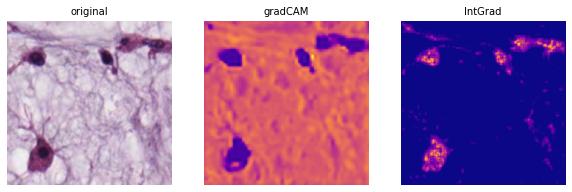

In [ ]:
index = 4
# grad-CAM and intgrad are inverted
image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmapsanddrops(model,image_batch[index],np.argmax(prediction[index]))

True label: Lympho
Predicted_label: Lympho
Confidence score for the correct label: 0.4517658
Normalized decrease in predicion score of Grad-CAM:  -1.1710540646571483
Normalized decrease in predicion score of integrated gradients:  -1.2135345925790617


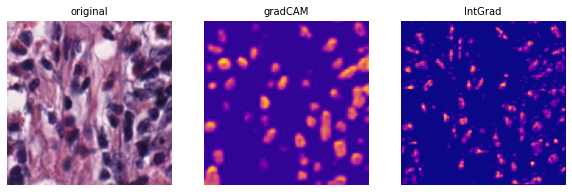

In [ ]:
index = 60
#intgrad has best margin of performance over gradcam here
image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmapsanddrops(model,image_batch[index],np.argmax(prediction[index]))

True label: Stroma
Predicted_label: Complex
Confidence score for the correct label: 0.4309024
Normalized decrease in predicion score of Grad-CAM:  -0.9947692038736172
Normalized decrease in predicion score of integrated gradients:  1.0


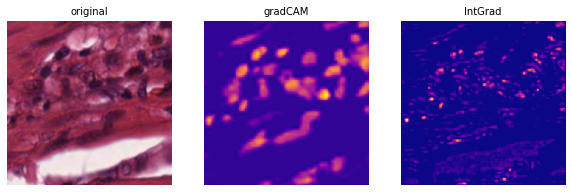

In [ ]:
index = 4
##gradcam has best margin of performance over intgrad here
image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmapsanddrops(model,image_batch[index],np.argmax(prediction[index]))

Note run using GPU if not integrated gradients will be wrong (it will be inverted) for some reason

In [ ]:
test_generator.reset()

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9613531
Normalized decrease in predicion score of Grad-CAM:  -0.019460678830350447
Normalized decrease in predicion score of integrated gradients:  0.05620599533840983


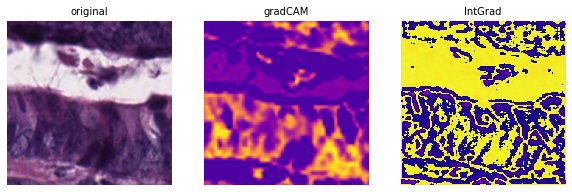

In [ ]:
index = 9
# run on cpu
image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmapsanddrops(model,image_batch[index],np.argmax(prediction[index]))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.96135336
Normalized decrease in predicion score of Grad-CAM:  -0.019460177997976915
Normalized decrease in predicion score of integrated gradients:  1.0


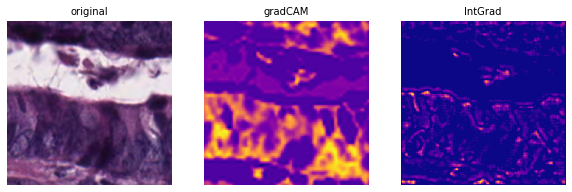

In [ ]:
index = 9
#run on GPU
image_batch,label_batch=test_generator.next()
prediction=model(image_batch)
print('True label: '+LABELS[np.argmax(label_batch[index])])
print('Predicted_label: '+LABELS[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))
dispheatmapsanddrops(model,image_batch[index],np.argmax(prediction[index]))